In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm 
import exchange_calendars as xcals

In [2]:
smh_price = pd.read_csv('data/SMH.csv')
smh_price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,220.550003,225.000000,216.559998,218.860001,217.694138,4650300
1,2021-01-05,218.449997,222.899994,218.449997,222.690002,221.503738,2319500
2,2021-01-06,220.830002,226.210007,219.940002,222.009995,220.827347,3844500
3,2021-01-07,225.800003,231.660004,225.800003,231.169998,229.938553,2622300
4,2021-01-08,235.119995,235.929993,227.860001,230.339996,229.112976,3364000
...,...,...,...,...,...,...,...
332,2022-04-28,232.410004,242.669998,229.669998,240.500000,240.500000,9548500
333,2022-04-29,235.929993,241.190002,229.429993,229.850006,229.850006,7243200
334,2022-05-02,229.889999,236.710007,227.729996,236.539993,236.539993,8199600
335,2022-05-03,235.720001,240.009995,234.110001,238.479996,238.479996,5312700


In [3]:
smh_price['Date'] = pd.to_datetime(smh_price['Date'])
smh_price = smh_price.set_index('Date')
business_day = xcals.get_calendar('NYSE').day
smh_price.index.freq = business_day
smh_close = smh_price['Close']
smh_close

Date
2021-01-04    218.860001
2021-01-05    222.690002
2021-01-06    222.009995
2021-01-07    231.169998
2021-01-08    230.339996
                 ...    
2022-04-28    240.500000
2022-04-29    229.850006
2022-05-02    236.539993
2022-05-03    238.479996
2022-05-04    246.660000
Freq: C, Name: Close, Length: 337, dtype: float64

<AxesSubplot:xlabel='Date'>

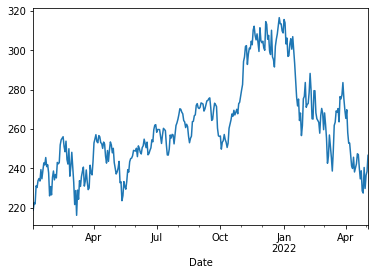

In [4]:
smh_close.plot()

Let's start with SARIMAX for prediction. We need to validate the predictions to make sure they seem reasonable

In [5]:
model = sm.tsa.SARIMAX(smh_close)
results = model.fit()
forecast_results = results.get_forecast('2022-05-06')
summary = forecast_results.summary_frame()
summary

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09495D+03    |proj g|=  2.17899D+03

At iterate    5    f=  1.51222D+01    |proj g|=  2.02089D+01

At iterate   10    f=  4.04021D+00    |proj g|=  7.98890D-01

At iterate   15    f=  3.25477D+00    |proj g|=  3.63498D-02

At iterate   20    f=  3.16318D+00    |proj g|=  2.07557D-03

At iterate   25    f=  3.15419D+00    |proj g|=  1.46525D-04

At iterate   30    f=  3.15389D+00    |proj g|=  2.90354D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/jonah/.virtualenvs/infer-pub/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-05-05,246.589665,5.606106,235.601899,257.577432
2022-05-06,246.519351,7.927101,230.982518,262.056183


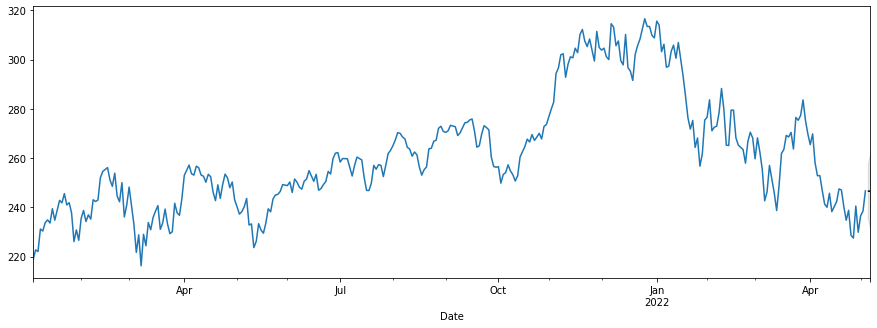

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
smh_close.plot(ax=ax)
fcast = results.get_forecast('2022-05-06').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

seems reasonable to me

In [11]:
mean = summary.loc['2022-05-6']['mean']
se = summary.loc['2022-05-6']['mean_se']
dist = norm(mean, se)
forecast = {
    "Less than $240": dist.cdf(240),
    "More than or equal to $240 but less than $260": dist.cdf(260) - dist.cdf(240),
    "More than or equal to $260 but less than $280": dist.cdf(280) - dist.cdf(260),
    "More than or equal to $280 but less than $300": dist.cdf(300) - dist.cdf(280),
    "More than or equal to $300": 1 - dist.cdf(300)
}
{k: f'{round(100*v)}%' for k, v in forecast.items()}

{'Less than $240': '21%',
 'More than or equal to $240 but less than $260': '75%',
 'More than or equal to $260 but less than $280': '4%',
 'More than or equal to $280 but less than $300': '0%',
 'More than or equal to $300': '0%'}